# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

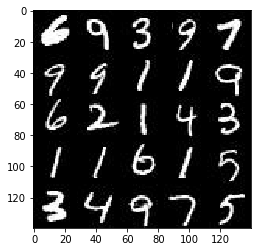

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

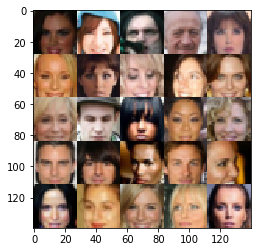

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32,(None,z_dim))
    lr = tf.placeholder(tf.float32,name='lr')

    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        h = tf.layers.conv2d(images, filters=32, kernel_size=5, strides=2,
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.maximum(0.2 * h, h)
        #h1 = tf.nn.relu(h1)
        
        h = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2,
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(0.2 * h, h)
        h = tf.nn.dropout(h, keep_prob=0.5)
        
        h = tf.layers.conv2d(h, filters=128, kernel_size=5, strides=2,
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(0.2 * h, h)
        h = tf.nn.dropout(h, keep_prob=0.5)
        
        h = tf.layers.conv2d(h, filters=256, kernel_size=5, strides=2,
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(0.2 * h, h)
        
        h = tf.reshape(h, [-1, 2*2*256])
        logits = tf.layers.dense(h, 1, activation=None)
        output = tf.sigmoid(logits)
    

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h = tf.layers.dense(z, units=4*4*512)
        h = tf.reshape(h, (-1, 4, 4, 512))
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum( 0.2 * h, h)
        
        h = tf.layers.conv2d_transpose(h, filters=128, kernel_size=4, strides=1, padding='valid')
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(0.2 * h, h)
        
        h = tf.layers.conv2d_transpose(h, filters=64, kernel_size=5, strides=2, padding='same')
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(0.2 * h, h)
        
        h = tf.layers.conv2d_transpose(h, filters=32, kernel_size=5, strides=2, padding='same')
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(0.2 * h, h)
        
        logits = tf.layers.conv2d_transpose(h, filters=out_channel_dim, kernel_size=3, strides=1,
                                            padding='same')
        out = tf.tanh(logits)
        print(out.get_shape())
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 28, 28, 5)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                           labels=tf.ones_like(disc_model_real)*(1-0.1)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                           labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                     labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    print(data_shape)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(disc_opt, feed_dict={input_real: batch_images,
                                              input_z: batch_z,
                                              lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_real: batch_images,
                                             input_z: batch_z,
                                             lr: learning_rate})
                
                i += 1
                if i % 10 == 0:
                    train_loss_disc = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: batch_z})
                    print('Epoch %d/%d Discriminator loss %.4f Generator loss %.4f' % (epoch_i+1,
                                                                                       epoch_count,
                                                                                       train_loss_disc,
                                                                                       train_loss_gen ))
                if i % 100 == 0:
                    show_generator_output(sess, 50, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 28, 28, 1)
(60000, 28, 28, 1)
Epoch 1/2 Discriminator loss 1.4153 Generator loss 0.7134
Epoch 1/2 Discriminator loss 2.0891 Generator loss 0.3239
Epoch 1/2 Discriminator loss 2.1108 Generator loss 0.3731
Epoch 1/2 Discriminator loss 1.7514 Generator loss 0.4467
Epoch 1/2 Discriminator loss 1.6342 Generator loss 0.5441
Epoch 1/2 Discriminator loss 1.7545 Generator loss 0.6893
Epoch 1/2 Discriminator loss 1.5822 Generator loss 0.6114
Epoch 1/2 Discriminator loss 1.5239 Generator loss 0.6239
Epoch 1/2 Discriminator loss 1.4123 Generator loss 1.1265
Epoch 1/2 Discriminator loss 1.5199 Generator loss 1.1860
(?, 28, 28, 1)


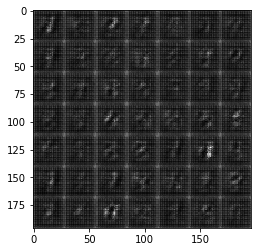

Epoch 1/2 Discriminator loss 1.4730 Generator loss 0.8807
Epoch 1/2 Discriminator loss 1.4209 Generator loss 0.8932
Epoch 1/2 Discriminator loss 1.3540 Generator loss 0.9053
Epoch 1/2 Discriminator loss 1.3683 Generator loss 0.9205
Epoch 1/2 Discriminator loss 1.4225 Generator loss 0.7686
Epoch 1/2 Discriminator loss 1.4605 Generator loss 0.6582
Epoch 1/2 Discriminator loss 1.4232 Generator loss 0.7034
Epoch 1/2 Discriminator loss 1.3542 Generator loss 0.7520
Epoch 1/2 Discriminator loss 1.3371 Generator loss 0.7663
Epoch 1/2 Discriminator loss 1.3412 Generator loss 0.8041
(?, 28, 28, 1)


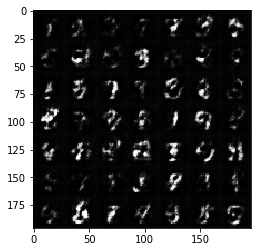

Epoch 1/2 Discriminator loss 1.3610 Generator loss 1.2161
Epoch 1/2 Discriminator loss 1.4183 Generator loss 0.9184
Epoch 1/2 Discriminator loss 1.3783 Generator loss 0.9331
Epoch 1/2 Discriminator loss 1.3855 Generator loss 1.1402
Epoch 1/2 Discriminator loss 1.3341 Generator loss 0.7805
Epoch 1/2 Discriminator loss 1.4069 Generator loss 1.0618
Epoch 1/2 Discriminator loss 1.3355 Generator loss 0.8913
Epoch 1/2 Discriminator loss 1.3385 Generator loss 0.9825
Epoch 1/2 Discriminator loss 1.4119 Generator loss 1.0010
Epoch 1/2 Discriminator loss 1.3794 Generator loss 0.7650
(?, 28, 28, 1)


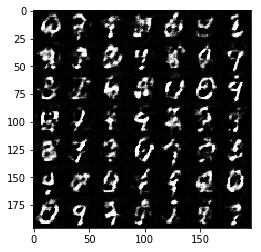

Epoch 1/2 Discriminator loss 1.4042 Generator loss 0.7074
Epoch 1/2 Discriminator loss 1.3591 Generator loss 0.7269
Epoch 1/2 Discriminator loss 1.3799 Generator loss 0.6667
Epoch 1/2 Discriminator loss 1.3897 Generator loss 0.6891
Epoch 1/2 Discriminator loss 1.5046 Generator loss 0.5257
Epoch 1/2 Discriminator loss 1.3843 Generator loss 0.6439
Epoch 1/2 Discriminator loss 1.3749 Generator loss 0.6834
Epoch 1/2 Discriminator loss 1.4947 Generator loss 0.5795
Epoch 1/2 Discriminator loss 1.4627 Generator loss 0.5895
Epoch 1/2 Discriminator loss 1.3603 Generator loss 0.9482
(?, 28, 28, 1)


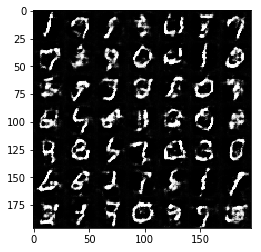

Epoch 1/2 Discriminator loss 1.3463 Generator loss 0.8915
Epoch 1/2 Discriminator loss 1.2863 Generator loss 0.8788
Epoch 1/2 Discriminator loss 1.4748 Generator loss 1.1969
Epoch 1/2 Discriminator loss 1.3862 Generator loss 0.7331
Epoch 1/2 Discriminator loss 1.4308 Generator loss 0.5547
Epoch 1/2 Discriminator loss 1.4377 Generator loss 0.6204
Epoch 1/2 Discriminator loss 1.3350 Generator loss 0.7402
Epoch 1/2 Discriminator loss 1.2913 Generator loss 0.8369
Epoch 1/2 Discriminator loss 1.3845 Generator loss 0.7238
Epoch 1/2 Discriminator loss 1.3698 Generator loss 0.7311
(?, 28, 28, 1)


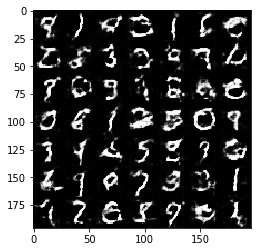

Epoch 1/2 Discriminator loss 1.3807 Generator loss 0.6309
Epoch 1/2 Discriminator loss 1.3414 Generator loss 0.7531
Epoch 1/2 Discriminator loss 1.3415 Generator loss 0.9046
Epoch 1/2 Discriminator loss 1.3248 Generator loss 0.9378
Epoch 1/2 Discriminator loss 1.3758 Generator loss 0.8648
Epoch 1/2 Discriminator loss 1.3764 Generator loss 0.9874
Epoch 1/2 Discriminator loss 1.4176 Generator loss 1.0608
Epoch 1/2 Discriminator loss 1.3718 Generator loss 0.9891
Epoch 1/2 Discriminator loss 1.3820 Generator loss 0.9652
Epoch 1/2 Discriminator loss 1.3604 Generator loss 1.1282
(?, 28, 28, 1)


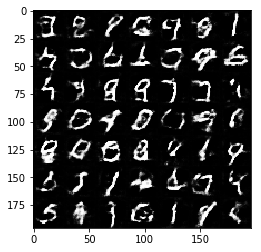

Epoch 1/2 Discriminator loss 1.3597 Generator loss 0.9515
Epoch 1/2 Discriminator loss 1.3574 Generator loss 0.7691
Epoch 1/2 Discriminator loss 1.3642 Generator loss 0.8462
Epoch 1/2 Discriminator loss 1.3684 Generator loss 0.6845
Epoch 1/2 Discriminator loss 1.4092 Generator loss 0.5920
Epoch 1/2 Discriminator loss 1.3672 Generator loss 0.7598
Epoch 1/2 Discriminator loss 1.3313 Generator loss 1.0122
Epoch 1/2 Discriminator loss 1.3859 Generator loss 0.7877
Epoch 1/2 Discriminator loss 1.3614 Generator loss 0.7889
Epoch 1/2 Discriminator loss 1.3506 Generator loss 0.7934
(?, 28, 28, 1)


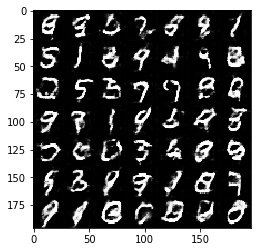

Epoch 1/2 Discriminator loss 1.3706 Generator loss 0.7063
Epoch 1/2 Discriminator loss 1.3798 Generator loss 0.6607
Epoch 1/2 Discriminator loss 1.3742 Generator loss 0.7026
Epoch 1/2 Discriminator loss 1.3317 Generator loss 0.7133
Epoch 1/2 Discriminator loss 1.3784 Generator loss 0.9176
Epoch 1/2 Discriminator loss 1.3438 Generator loss 0.6927
Epoch 1/2 Discriminator loss 1.3278 Generator loss 0.6785
Epoch 1/2 Discriminator loss 1.4247 Generator loss 0.6001
Epoch 1/2 Discriminator loss 1.3324 Generator loss 0.7524
Epoch 1/2 Discriminator loss 1.3084 Generator loss 0.8050
(?, 28, 28, 1)


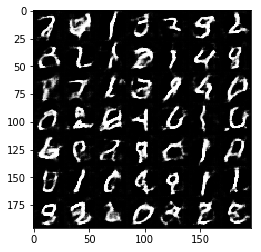

Epoch 1/2 Discriminator loss 1.3323 Generator loss 0.8537
Epoch 1/2 Discriminator loss 1.3485 Generator loss 0.7245
Epoch 1/2 Discriminator loss 1.3313 Generator loss 0.8417
Epoch 1/2 Discriminator loss 1.3514 Generator loss 1.0207
Epoch 1/2 Discriminator loss 1.3619 Generator loss 0.9308
Epoch 1/2 Discriminator loss 1.3648 Generator loss 0.8289
Epoch 1/2 Discriminator loss 1.3572 Generator loss 0.6808
Epoch 1/2 Discriminator loss 1.3461 Generator loss 0.7794
Epoch 1/2 Discriminator loss 1.3270 Generator loss 0.7563
Epoch 1/2 Discriminator loss 1.3343 Generator loss 1.0422
(?, 28, 28, 1)


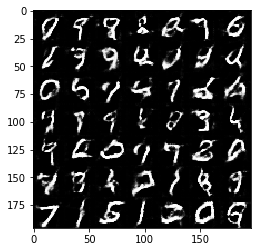

Epoch 1/2 Discriminator loss 1.3637 Generator loss 0.8807
Epoch 1/2 Discriminator loss 1.3346 Generator loss 0.9524
Epoch 1/2 Discriminator loss 1.3281 Generator loss 1.0232
Epoch 2/2 Discriminator loss 1.3681 Generator loss 0.8749
Epoch 2/2 Discriminator loss 1.3443 Generator loss 0.8347
Epoch 2/2 Discriminator loss 1.3181 Generator loss 0.8096
Epoch 2/2 Discriminator loss 1.3354 Generator loss 0.7837
Epoch 2/2 Discriminator loss 1.3857 Generator loss 1.1335
Epoch 2/2 Discriminator loss 1.3626 Generator loss 0.7642
Epoch 2/2 Discriminator loss 1.3443 Generator loss 0.7550
(?, 28, 28, 1)


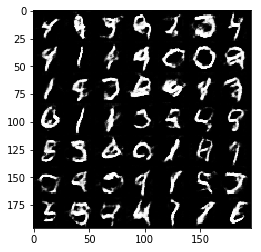

Epoch 2/2 Discriminator loss 1.3144 Generator loss 0.8989
Epoch 2/2 Discriminator loss 1.3495 Generator loss 0.7097
Epoch 2/2 Discriminator loss 1.3969 Generator loss 0.5953
Epoch 2/2 Discriminator loss 1.3909 Generator loss 0.7265
Epoch 2/2 Discriminator loss 1.3628 Generator loss 0.9327
Epoch 2/2 Discriminator loss 1.3341 Generator loss 0.9485
Epoch 2/2 Discriminator loss 1.3267 Generator loss 0.8400
Epoch 2/2 Discriminator loss 1.3113 Generator loss 0.8256
Epoch 2/2 Discriminator loss 1.3268 Generator loss 1.0262
Epoch 2/2 Discriminator loss 1.2933 Generator loss 0.9484
(?, 28, 28, 1)


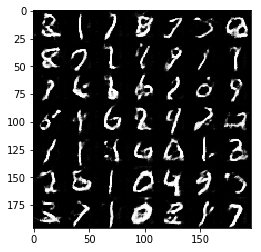

Epoch 2/2 Discriminator loss 1.3254 Generator loss 0.7152
Epoch 2/2 Discriminator loss 1.3920 Generator loss 0.7790
Epoch 2/2 Discriminator loss 1.2796 Generator loss 0.8251
Epoch 2/2 Discriminator loss 1.3877 Generator loss 0.8197
Epoch 2/2 Discriminator loss 1.3781 Generator loss 0.5494
Epoch 2/2 Discriminator loss 1.3797 Generator loss 0.6854
Epoch 2/2 Discriminator loss 1.3475 Generator loss 0.7226
Epoch 2/2 Discriminator loss 1.3755 Generator loss 0.7999
Epoch 2/2 Discriminator loss 1.3501 Generator loss 0.6121
Epoch 2/2 Discriminator loss 1.3465 Generator loss 0.6932
(?, 28, 28, 1)


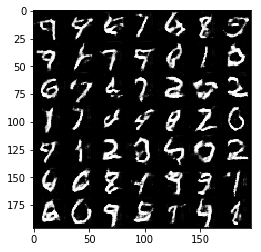

Epoch 2/2 Discriminator loss 1.3471 Generator loss 0.7699
Epoch 2/2 Discriminator loss 1.3961 Generator loss 0.7191
Epoch 2/2 Discriminator loss 1.3304 Generator loss 0.8953
Epoch 2/2 Discriminator loss 1.3276 Generator loss 0.7251
Epoch 2/2 Discriminator loss 1.3959 Generator loss 0.6552
Epoch 2/2 Discriminator loss 1.3365 Generator loss 0.6750
Epoch 2/2 Discriminator loss 1.2906 Generator loss 0.8095
Epoch 2/2 Discriminator loss 1.3501 Generator loss 0.7691
Epoch 2/2 Discriminator loss 1.3528 Generator loss 0.8112
Epoch 2/2 Discriminator loss 1.2855 Generator loss 0.8938
(?, 28, 28, 1)


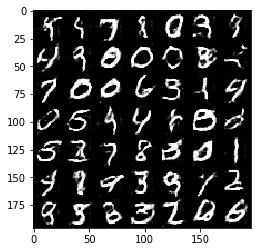

Epoch 2/2 Discriminator loss 1.4088 Generator loss 1.0646
Epoch 2/2 Discriminator loss 1.3191 Generator loss 0.9544
Epoch 2/2 Discriminator loss 1.3793 Generator loss 1.0126
Epoch 2/2 Discriminator loss 1.3365 Generator loss 0.8522
Epoch 2/2 Discriminator loss 1.4201 Generator loss 0.9550
Epoch 2/2 Discriminator loss 1.3180 Generator loss 0.9289
Epoch 2/2 Discriminator loss 1.2795 Generator loss 0.9007
Epoch 2/2 Discriminator loss 1.3886 Generator loss 1.0017
Epoch 2/2 Discriminator loss 1.3294 Generator loss 1.0246
Epoch 2/2 Discriminator loss 1.3592 Generator loss 1.0032
(?, 28, 28, 1)


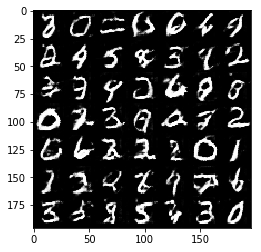

Epoch 2/2 Discriminator loss 1.3563 Generator loss 0.8914
Epoch 2/2 Discriminator loss 1.3308 Generator loss 0.8879
Epoch 2/2 Discriminator loss 1.3788 Generator loss 0.9160
Epoch 2/2 Discriminator loss 1.3681 Generator loss 0.7593
Epoch 2/2 Discriminator loss 1.3853 Generator loss 1.0165
Epoch 2/2 Discriminator loss 1.4101 Generator loss 1.0488
Epoch 2/2 Discriminator loss 1.2903 Generator loss 0.7899
Epoch 2/2 Discriminator loss 1.3949 Generator loss 0.6823
Epoch 2/2 Discriminator loss 1.3555 Generator loss 0.6720
Epoch 2/2 Discriminator loss 1.3390 Generator loss 0.7674
(?, 28, 28, 1)


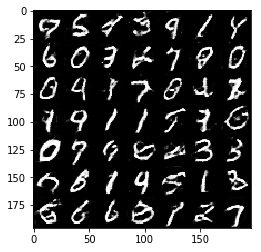

Epoch 2/2 Discriminator loss 1.3318 Generator loss 0.7687
Epoch 2/2 Discriminator loss 1.3364 Generator loss 0.9134
Epoch 2/2 Discriminator loss 1.4221 Generator loss 1.1588
Epoch 2/2 Discriminator loss 1.3067 Generator loss 0.9163
Epoch 2/2 Discriminator loss 1.3530 Generator loss 0.7238
Epoch 2/2 Discriminator loss 1.3259 Generator loss 0.8553
Epoch 2/2 Discriminator loss 1.3658 Generator loss 0.6526
Epoch 2/2 Discriminator loss 1.3283 Generator loss 0.8339
Epoch 2/2 Discriminator loss 1.3842 Generator loss 0.9965
Epoch 2/2 Discriminator loss 1.3372 Generator loss 0.9770
(?, 28, 28, 1)


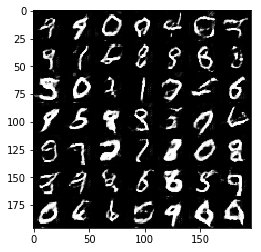

Epoch 2/2 Discriminator loss 1.3436 Generator loss 1.0293
Epoch 2/2 Discriminator loss 1.2974 Generator loss 0.8231
Epoch 2/2 Discriminator loss 1.3302 Generator loss 0.8739
Epoch 2/2 Discriminator loss 1.2472 Generator loss 0.7777
Epoch 2/2 Discriminator loss 1.3107 Generator loss 0.7579
Epoch 2/2 Discriminator loss 1.3443 Generator loss 0.7748
Epoch 2/2 Discriminator loss 1.2826 Generator loss 0.8912
Epoch 2/2 Discriminator loss 1.3116 Generator loss 0.7887
Epoch 2/2 Discriminator loss 1.3715 Generator loss 1.1659
Epoch 2/2 Discriminator loss 1.3517 Generator loss 1.0462
(?, 28, 28, 1)


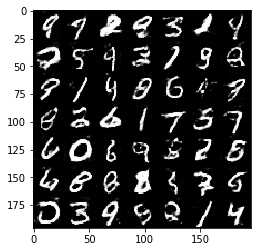

Epoch 2/2 Discriminator loss 1.3542 Generator loss 0.8160
Epoch 2/2 Discriminator loss 1.2958 Generator loss 0.8103
Epoch 2/2 Discriminator loss 1.2787 Generator loss 0.8308
Epoch 2/2 Discriminator loss 1.3655 Generator loss 0.7979
Epoch 2/2 Discriminator loss 1.3985 Generator loss 0.6086
Epoch 2/2 Discriminator loss 1.3239 Generator loss 0.7556
Epoch 2/2 Discriminator loss 1.2871 Generator loss 1.0889
Epoch 2/2 Discriminator loss 1.4035 Generator loss 1.0349
Epoch 2/2 Discriminator loss 1.3216 Generator loss 0.8591
Epoch 2/2 Discriminator loss 1.4099 Generator loss 1.1824
(?, 28, 28, 1)


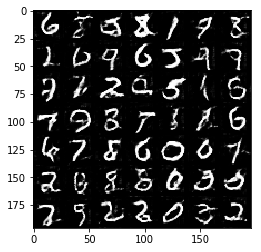

Epoch 2/2 Discriminator loss 1.3506 Generator loss 0.9196
Epoch 2/2 Discriminator loss 1.3352 Generator loss 0.8757
Epoch 2/2 Discriminator loss 1.3651 Generator loss 0.8489
Epoch 2/2 Discriminator loss 1.3876 Generator loss 1.1512
Epoch 2/2 Discriminator loss 1.2989 Generator loss 0.7324
Epoch 2/2 Discriminator loss 1.3835 Generator loss 0.7046
Epoch 2/2 Discriminator loss 1.3785 Generator loss 0.5977


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 28, 28, 3)
(202599, 28, 28, 3)
Epoch 1/1 Discriminator loss 1.5046 Generator loss 3.0393
Epoch 1/1 Discriminator loss 1.3456 Generator loss 3.5172
Epoch 1/1 Discriminator loss 1.3629 Generator loss 1.9419
Epoch 1/1 Discriminator loss 1.2601 Generator loss 3.4037
Epoch 1/1 Discriminator loss 1.1400 Generator loss 3.0358
Epoch 1/1 Discriminator loss 1.0581 Generator loss 1.4458
Epoch 1/1 Discriminator loss 0.8786 Generator loss 1.9313
Epoch 1/1 Discriminator loss 1.1701 Generator loss 1.6940
Epoch 1/1 Discriminator loss 1.4378 Generator loss 1.2798
Epoch 1/1 Discriminator loss 1.2299 Generator loss 0.9636
(?, 28, 28, 3)


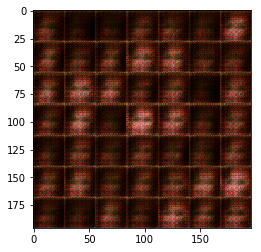

Epoch 1/1 Discriminator loss 1.2691 Generator loss 0.8543
Epoch 1/1 Discriminator loss 1.2803 Generator loss 1.6315
Epoch 1/1 Discriminator loss 1.2633 Generator loss 0.7732
Epoch 1/1 Discriminator loss 1.2834 Generator loss 1.0307
Epoch 1/1 Discriminator loss 1.4092 Generator loss 0.8698
Epoch 1/1 Discriminator loss 1.4136 Generator loss 0.6610
Epoch 1/1 Discriminator loss 1.3827 Generator loss 0.8537
Epoch 1/1 Discriminator loss 1.3570 Generator loss 1.0967
Epoch 1/1 Discriminator loss 1.2054 Generator loss 1.1049
Epoch 1/1 Discriminator loss 1.2521 Generator loss 1.2976
(?, 28, 28, 3)


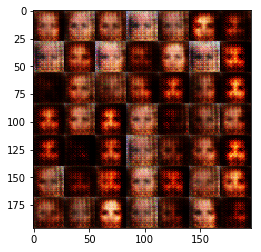

Epoch 1/1 Discriminator loss 1.3818 Generator loss 0.9818
Epoch 1/1 Discriminator loss 1.3410 Generator loss 0.8906
Epoch 1/1 Discriminator loss 1.3768 Generator loss 0.9246
Epoch 1/1 Discriminator loss 1.3554 Generator loss 1.2900
Epoch 1/1 Discriminator loss 1.2453 Generator loss 1.1101
Epoch 1/1 Discriminator loss 1.2432 Generator loss 1.0147
Epoch 1/1 Discriminator loss 1.5189 Generator loss 0.5246
Epoch 1/1 Discriminator loss 1.2963 Generator loss 0.7681
Epoch 1/1 Discriminator loss 1.2912 Generator loss 1.0888
Epoch 1/1 Discriminator loss 1.3116 Generator loss 1.1460
(?, 28, 28, 3)


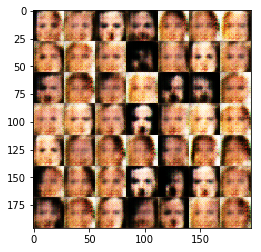

Epoch 1/1 Discriminator loss 1.2092 Generator loss 1.2910
Epoch 1/1 Discriminator loss 1.4750 Generator loss 1.4504
Epoch 1/1 Discriminator loss 1.2204 Generator loss 1.2503
Epoch 1/1 Discriminator loss 1.4261 Generator loss 0.6040
Epoch 1/1 Discriminator loss 1.3113 Generator loss 1.2762
Epoch 1/1 Discriminator loss 1.2380 Generator loss 0.9078
Epoch 1/1 Discriminator loss 1.2908 Generator loss 0.7106
Epoch 1/1 Discriminator loss 1.4254 Generator loss 0.5097
Epoch 1/1 Discriminator loss 1.4232 Generator loss 0.5492
Epoch 1/1 Discriminator loss 1.3339 Generator loss 1.1533
(?, 28, 28, 3)


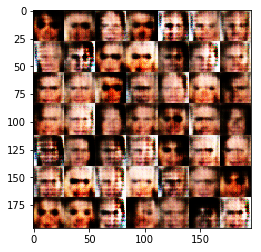

Epoch 1/1 Discriminator loss 1.2766 Generator loss 0.7884
Epoch 1/1 Discriminator loss 1.4484 Generator loss 0.7397
Epoch 1/1 Discriminator loss 1.4204 Generator loss 1.1164
Epoch 1/1 Discriminator loss 1.4074 Generator loss 0.7365
Epoch 1/1 Discriminator loss 1.4207 Generator loss 0.5525
Epoch 1/1 Discriminator loss 1.2847 Generator loss 0.9374
Epoch 1/1 Discriminator loss 1.2945 Generator loss 0.9560
Epoch 1/1 Discriminator loss 1.3491 Generator loss 0.7222
Epoch 1/1 Discriminator loss 1.5146 Generator loss 0.5331
Epoch 1/1 Discriminator loss 1.2964 Generator loss 0.7926
(?, 28, 28, 3)


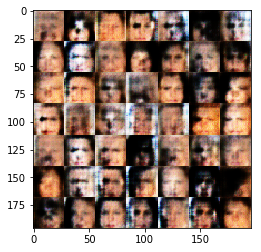

Epoch 1/1 Discriminator loss 1.3236 Generator loss 0.7804
Epoch 1/1 Discriminator loss 1.2458 Generator loss 0.8907
Epoch 1/1 Discriminator loss 1.4022 Generator loss 0.5570
Epoch 1/1 Discriminator loss 1.3745 Generator loss 0.7603
Epoch 1/1 Discriminator loss 1.3455 Generator loss 1.2345
Epoch 1/1 Discriminator loss 1.2257 Generator loss 0.9370
Epoch 1/1 Discriminator loss 1.3941 Generator loss 1.1792
Epoch 1/1 Discriminator loss 1.4280 Generator loss 1.0063
Epoch 1/1 Discriminator loss 1.3287 Generator loss 1.1710
Epoch 1/1 Discriminator loss 1.3785 Generator loss 1.4815
(?, 28, 28, 3)


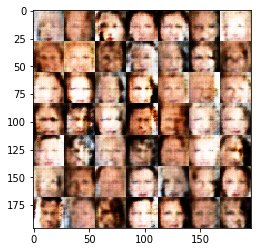

Epoch 1/1 Discriminator loss 1.4007 Generator loss 0.9345
Epoch 1/1 Discriminator loss 1.3391 Generator loss 1.1391
Epoch 1/1 Discriminator loss 1.4329 Generator loss 0.6832
Epoch 1/1 Discriminator loss 1.2962 Generator loss 0.7867
Epoch 1/1 Discriminator loss 1.2594 Generator loss 0.7577
Epoch 1/1 Discriminator loss 1.3895 Generator loss 1.1738
Epoch 1/1 Discriminator loss 1.3664 Generator loss 0.7078
Epoch 1/1 Discriminator loss 1.1456 Generator loss 1.1302
Epoch 1/1 Discriminator loss 1.2489 Generator loss 0.9532
Epoch 1/1 Discriminator loss 1.2507 Generator loss 0.9734
(?, 28, 28, 3)


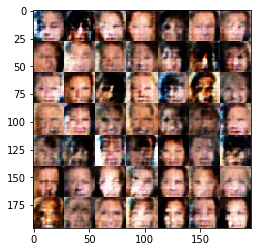

Epoch 1/1 Discriminator loss 1.4313 Generator loss 1.2643
Epoch 1/1 Discriminator loss 1.2857 Generator loss 0.7462
Epoch 1/1 Discriminator loss 1.3799 Generator loss 0.7437
Epoch 1/1 Discriminator loss 1.3754 Generator loss 0.8571
Epoch 1/1 Discriminator loss 1.3408 Generator loss 0.8244
Epoch 1/1 Discriminator loss 1.4064 Generator loss 0.9216
Epoch 1/1 Discriminator loss 1.3609 Generator loss 1.3166
Epoch 1/1 Discriminator loss 1.4581 Generator loss 0.5748
Epoch 1/1 Discriminator loss 1.3858 Generator loss 0.8102
Epoch 1/1 Discriminator loss 1.3299 Generator loss 0.8182
(?, 28, 28, 3)


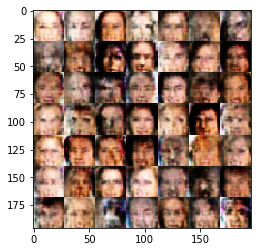

Epoch 1/1 Discriminator loss 1.4365 Generator loss 0.6489
Epoch 1/1 Discriminator loss 1.3932 Generator loss 1.0416
Epoch 1/1 Discriminator loss 1.4610 Generator loss 1.0958
Epoch 1/1 Discriminator loss 1.4877 Generator loss 0.6793
Epoch 1/1 Discriminator loss 1.2239 Generator loss 0.8779
Epoch 1/1 Discriminator loss 1.3853 Generator loss 0.7954
Epoch 1/1 Discriminator loss 1.4538 Generator loss 0.9421
Epoch 1/1 Discriminator loss 1.2551 Generator loss 0.7531
Epoch 1/1 Discriminator loss 1.3865 Generator loss 0.8558
Epoch 1/1 Discriminator loss 1.3801 Generator loss 0.7411
(?, 28, 28, 3)


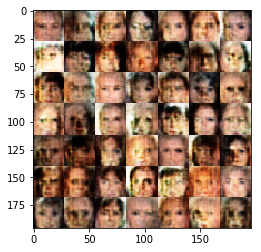

Epoch 1/1 Discriminator loss 1.2932 Generator loss 0.7602
Epoch 1/1 Discriminator loss 1.2836 Generator loss 0.8111
Epoch 1/1 Discriminator loss 1.3108 Generator loss 1.1012
Epoch 1/1 Discriminator loss 1.4243 Generator loss 0.8419
Epoch 1/1 Discriminator loss 1.3255 Generator loss 0.6416
Epoch 1/1 Discriminator loss 1.4749 Generator loss 0.5472
Epoch 1/1 Discriminator loss 1.4067 Generator loss 1.0157
Epoch 1/1 Discriminator loss 1.3608 Generator loss 0.7215
Epoch 1/1 Discriminator loss 1.3827 Generator loss 1.3295
Epoch 1/1 Discriminator loss 1.2656 Generator loss 0.7315
(?, 28, 28, 3)


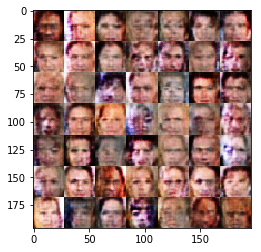

Epoch 1/1 Discriminator loss 1.3809 Generator loss 0.8881
Epoch 1/1 Discriminator loss 1.3630 Generator loss 0.7458
Epoch 1/1 Discriminator loss 1.3207 Generator loss 0.7938
Epoch 1/1 Discriminator loss 1.2957 Generator loss 0.9391
Epoch 1/1 Discriminator loss 1.4146 Generator loss 0.7799
Epoch 1/1 Discriminator loss 1.3559 Generator loss 0.8673
Epoch 1/1 Discriminator loss 1.3877 Generator loss 0.9322
Epoch 1/1 Discriminator loss 1.3213 Generator loss 0.8243
Epoch 1/1 Discriminator loss 1.3794 Generator loss 1.0572
Epoch 1/1 Discriminator loss 1.2001 Generator loss 1.0163
(?, 28, 28, 3)


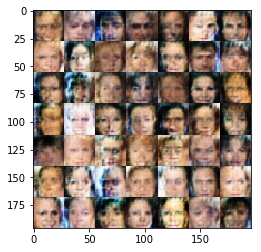

Epoch 1/1 Discriminator loss 1.2722 Generator loss 0.8032
Epoch 1/1 Discriminator loss 1.4176 Generator loss 0.7893
Epoch 1/1 Discriminator loss 1.3955 Generator loss 0.7359
Epoch 1/1 Discriminator loss 1.3124 Generator loss 0.7857
Epoch 1/1 Discriminator loss 1.3394 Generator loss 0.7096
Epoch 1/1 Discriminator loss 1.3212 Generator loss 0.7716
Epoch 1/1 Discriminator loss 1.4084 Generator loss 0.6159
Epoch 1/1 Discriminator loss 1.2522 Generator loss 0.8072
Epoch 1/1 Discriminator loss 1.3334 Generator loss 0.7711
Epoch 1/1 Discriminator loss 1.2897 Generator loss 0.8165
(?, 28, 28, 3)


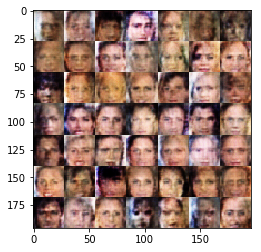

Epoch 1/1 Discriminator loss 1.2573 Generator loss 0.8459
Epoch 1/1 Discriminator loss 1.2440 Generator loss 0.9868
Epoch 1/1 Discriminator loss 1.3734 Generator loss 0.9312
Epoch 1/1 Discriminator loss 1.3148 Generator loss 0.8163
Epoch 1/1 Discriminator loss 1.3613 Generator loss 0.7630
Epoch 1/1 Discriminator loss 1.3587 Generator loss 0.8058
Epoch 1/1 Discriminator loss 1.2799 Generator loss 0.8341
Epoch 1/1 Discriminator loss 1.3294 Generator loss 0.8913
Epoch 1/1 Discriminator loss 1.3187 Generator loss 0.8043
Epoch 1/1 Discriminator loss 1.3382 Generator loss 0.7818
(?, 28, 28, 3)


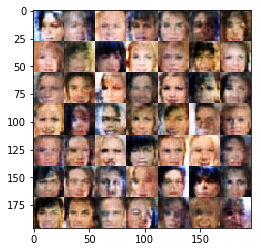

Epoch 1/1 Discriminator loss 1.3615 Generator loss 0.8274
Epoch 1/1 Discriminator loss 1.3538 Generator loss 0.8537
Epoch 1/1 Discriminator loss 1.3997 Generator loss 0.9009
Epoch 1/1 Discriminator loss 1.3309 Generator loss 0.7012
Epoch 1/1 Discriminator loss 1.3533 Generator loss 0.7961
Epoch 1/1 Discriminator loss 1.3499 Generator loss 0.8050
Epoch 1/1 Discriminator loss 1.3780 Generator loss 0.7004
Epoch 1/1 Discriminator loss 1.2996 Generator loss 0.7186
Epoch 1/1 Discriminator loss 1.3558 Generator loss 0.7117
Epoch 1/1 Discriminator loss 1.2902 Generator loss 0.9115
(?, 28, 28, 3)


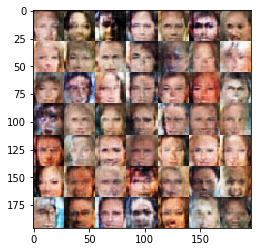

Epoch 1/1 Discriminator loss 1.3290 Generator loss 0.8342
Epoch 1/1 Discriminator loss 1.2958 Generator loss 0.8759
Epoch 1/1 Discriminator loss 1.3405 Generator loss 0.7287
Epoch 1/1 Discriminator loss 1.3780 Generator loss 0.8294
Epoch 1/1 Discriminator loss 1.3337 Generator loss 0.6831
Epoch 1/1 Discriminator loss 1.3495 Generator loss 0.6738
Epoch 1/1 Discriminator loss 1.3901 Generator loss 0.7220
Epoch 1/1 Discriminator loss 1.3998 Generator loss 1.1414
Epoch 1/1 Discriminator loss 1.3597 Generator loss 0.7553
Epoch 1/1 Discriminator loss 1.3540 Generator loss 0.7654
(?, 28, 28, 3)


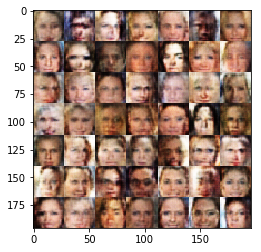

Epoch 1/1 Discriminator loss 1.3834 Generator loss 0.7882
Epoch 1/1 Discriminator loss 1.3923 Generator loss 0.6882
Epoch 1/1 Discriminator loss 1.3915 Generator loss 0.7408
Epoch 1/1 Discriminator loss 1.4330 Generator loss 0.7234
Epoch 1/1 Discriminator loss 1.3129 Generator loss 0.7691
Epoch 1/1 Discriminator loss 1.3330 Generator loss 0.8865
Epoch 1/1 Discriminator loss 1.3691 Generator loss 0.8086
Epoch 1/1 Discriminator loss 1.3364 Generator loss 0.7749
Epoch 1/1 Discriminator loss 1.4093 Generator loss 0.8832
Epoch 1/1 Discriminator loss 1.3182 Generator loss 0.8212
(?, 28, 28, 3)


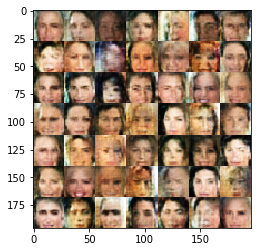

Epoch 1/1 Discriminator loss 1.3944 Generator loss 0.6868
Epoch 1/1 Discriminator loss 1.3360 Generator loss 0.8351
Epoch 1/1 Discriminator loss 1.4023 Generator loss 0.7650
Epoch 1/1 Discriminator loss 1.3699 Generator loss 0.8113
Epoch 1/1 Discriminator loss 1.4137 Generator loss 0.5937
Epoch 1/1 Discriminator loss 1.3143 Generator loss 0.8186
Epoch 1/1 Discriminator loss 1.3967 Generator loss 0.7864
Epoch 1/1 Discriminator loss 1.3969 Generator loss 0.7651
Epoch 1/1 Discriminator loss 1.4210 Generator loss 0.7734
Epoch 1/1 Discriminator loss 1.3936 Generator loss 1.0442
(?, 28, 28, 3)


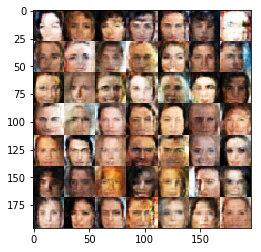

Epoch 1/1 Discriminator loss 1.3350 Generator loss 0.8134
Epoch 1/1 Discriminator loss 1.4297 Generator loss 0.6649
Epoch 1/1 Discriminator loss 1.3487 Generator loss 0.8107
Epoch 1/1 Discriminator loss 1.3524 Generator loss 0.7780
Epoch 1/1 Discriminator loss 1.3456 Generator loss 0.8581
Epoch 1/1 Discriminator loss 1.3401 Generator loss 0.8444
Epoch 1/1 Discriminator loss 1.3384 Generator loss 0.7656
Epoch 1/1 Discriminator loss 1.1997 Generator loss 0.9645
Epoch 1/1 Discriminator loss 1.3405 Generator loss 0.8247
Epoch 1/1 Discriminator loss 1.4260 Generator loss 0.7575
(?, 28, 28, 3)


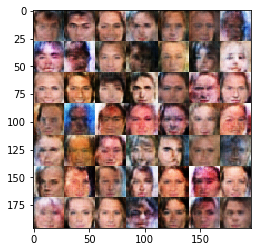

Epoch 1/1 Discriminator loss 1.3540 Generator loss 0.7851
Epoch 1/1 Discriminator loss 1.4972 Generator loss 0.6870
Epoch 1/1 Discriminator loss 1.3676 Generator loss 0.7882
Epoch 1/1 Discriminator loss 1.2979 Generator loss 0.9341
Epoch 1/1 Discriminator loss 1.3106 Generator loss 0.7775
Epoch 1/1 Discriminator loss 1.3124 Generator loss 0.8053
Epoch 1/1 Discriminator loss 1.3982 Generator loss 0.8251
Epoch 1/1 Discriminator loss 1.3157 Generator loss 0.7534
Epoch 1/1 Discriminator loss 1.3464 Generator loss 0.7550
Epoch 1/1 Discriminator loss 1.3694 Generator loss 0.7869
(?, 28, 28, 3)


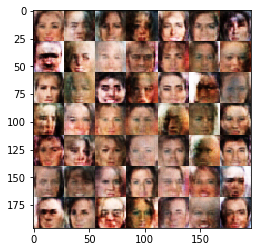

Epoch 1/1 Discriminator loss 1.3151 Generator loss 0.7590
Epoch 1/1 Discriminator loss 1.3599 Generator loss 0.8223
Epoch 1/1 Discriminator loss 1.3205 Generator loss 0.9637
Epoch 1/1 Discriminator loss 1.3979 Generator loss 0.8826
Epoch 1/1 Discriminator loss 1.3182 Generator loss 0.8178
Epoch 1/1 Discriminator loss 1.4121 Generator loss 0.7852
Epoch 1/1 Discriminator loss 1.3855 Generator loss 0.7583
Epoch 1/1 Discriminator loss 1.3841 Generator loss 0.8478
Epoch 1/1 Discriminator loss 1.3490 Generator loss 0.8015
Epoch 1/1 Discriminator loss 1.3507 Generator loss 0.8277
(?, 28, 28, 3)


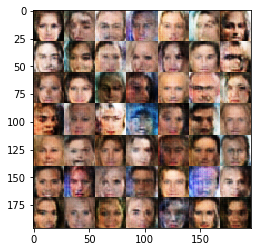

Epoch 1/1 Discriminator loss 1.3119 Generator loss 0.8698
Epoch 1/1 Discriminator loss 1.3235 Generator loss 0.8317
Epoch 1/1 Discriminator loss 1.4180 Generator loss 0.7309
Epoch 1/1 Discriminator loss 1.3728 Generator loss 0.8873
Epoch 1/1 Discriminator loss 1.3761 Generator loss 0.7269
Epoch 1/1 Discriminator loss 1.3029 Generator loss 0.8095
Epoch 1/1 Discriminator loss 1.3851 Generator loss 0.7549
Epoch 1/1 Discriminator loss 1.3741 Generator loss 0.7992
Epoch 1/1 Discriminator loss 1.2778 Generator loss 0.8096
Epoch 1/1 Discriminator loss 1.3212 Generator loss 0.9506
(?, 28, 28, 3)


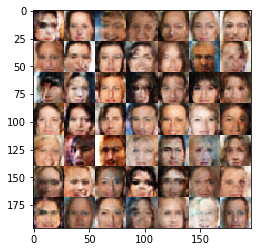

Epoch 1/1 Discriminator loss 1.3408 Generator loss 0.8162
Epoch 1/1 Discriminator loss 1.3366 Generator loss 0.8423
Epoch 1/1 Discriminator loss 1.3998 Generator loss 0.8202
Epoch 1/1 Discriminator loss 1.3791 Generator loss 0.7974
Epoch 1/1 Discriminator loss 1.3937 Generator loss 0.8935
Epoch 1/1 Discriminator loss 1.3617 Generator loss 0.6613
Epoch 1/1 Discriminator loss 1.3871 Generator loss 0.9125
Epoch 1/1 Discriminator loss 1.3665 Generator loss 0.7653
Epoch 1/1 Discriminator loss 1.3603 Generator loss 0.8204
Epoch 1/1 Discriminator loss 1.3126 Generator loss 0.8032
(?, 28, 28, 3)


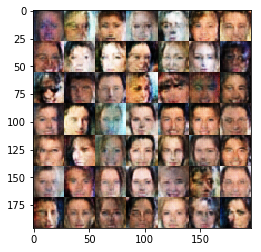

Epoch 1/1 Discriminator loss 1.3902 Generator loss 0.7485
Epoch 1/1 Discriminator loss 1.3204 Generator loss 0.8548
Epoch 1/1 Discriminator loss 1.3745 Generator loss 0.7804
Epoch 1/1 Discriminator loss 1.3473 Generator loss 0.7815
Epoch 1/1 Discriminator loss 1.3677 Generator loss 0.7612
Epoch 1/1 Discriminator loss 1.3566 Generator loss 0.8523
Epoch 1/1 Discriminator loss 1.3863 Generator loss 0.7754
Epoch 1/1 Discriminator loss 1.3536 Generator loss 0.9013
Epoch 1/1 Discriminator loss 1.3425 Generator loss 0.8212
Epoch 1/1 Discriminator loss 1.3701 Generator loss 0.7574
(?, 28, 28, 3)


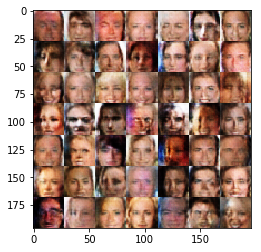

Epoch 1/1 Discriminator loss 1.2595 Generator loss 0.8835
Epoch 1/1 Discriminator loss 1.3741 Generator loss 0.9447
Epoch 1/1 Discriminator loss 1.3560 Generator loss 0.7210
Epoch 1/1 Discriminator loss 1.3509 Generator loss 0.7199
Epoch 1/1 Discriminator loss 1.3238 Generator loss 0.8837
Epoch 1/1 Discriminator loss 1.3706 Generator loss 0.7935
Epoch 1/1 Discriminator loss 1.3221 Generator loss 0.8434
Epoch 1/1 Discriminator loss 1.3165 Generator loss 0.7881
Epoch 1/1 Discriminator loss 1.3609 Generator loss 0.7849
Epoch 1/1 Discriminator loss 1.3619 Generator loss 0.8536
(?, 28, 28, 3)


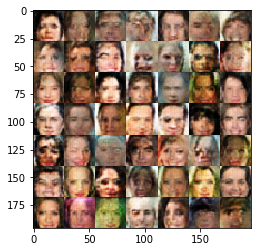

Epoch 1/1 Discriminator loss 1.3664 Generator loss 0.7376
Epoch 1/1 Discriminator loss 1.3631 Generator loss 0.7853
Epoch 1/1 Discriminator loss 1.3229 Generator loss 0.8052
Epoch 1/1 Discriminator loss 1.3914 Generator loss 0.7776
Epoch 1/1 Discriminator loss 1.3600 Generator loss 0.8467
Epoch 1/1 Discriminator loss 1.3605 Generator loss 0.7959
Epoch 1/1 Discriminator loss 1.3946 Generator loss 0.7635
Epoch 1/1 Discriminator loss 1.3515 Generator loss 0.7834
Epoch 1/1 Discriminator loss 1.4256 Generator loss 0.7569
Epoch 1/1 Discriminator loss 1.3779 Generator loss 0.7492
(?, 28, 28, 3)


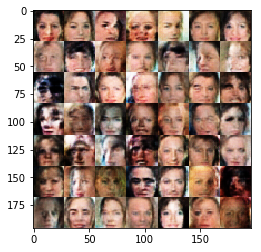

Epoch 1/1 Discriminator loss 1.3255 Generator loss 0.7528
Epoch 1/1 Discriminator loss 1.4048 Generator loss 0.7548
Epoch 1/1 Discriminator loss 1.4313 Generator loss 0.8190
Epoch 1/1 Discriminator loss 1.3350 Generator loss 0.7588
Epoch 1/1 Discriminator loss 1.3407 Generator loss 0.9451
Epoch 1/1 Discriminator loss 1.2959 Generator loss 0.7696
Epoch 1/1 Discriminator loss 1.3704 Generator loss 0.7431
Epoch 1/1 Discriminator loss 1.4237 Generator loss 0.7460
Epoch 1/1 Discriminator loss 1.3041 Generator loss 0.7787
Epoch 1/1 Discriminator loss 1.3471 Generator loss 0.8280
(?, 28, 28, 3)


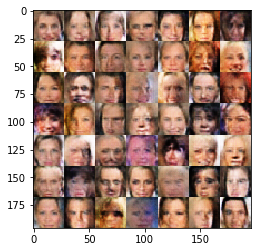

Epoch 1/1 Discriminator loss 1.3329 Generator loss 0.8858
Epoch 1/1 Discriminator loss 1.3400 Generator loss 0.7778
Epoch 1/1 Discriminator loss 1.3175 Generator loss 0.7934
Epoch 1/1 Discriminator loss 1.2919 Generator loss 0.9033
Epoch 1/1 Discriminator loss 1.3826 Generator loss 0.6860
Epoch 1/1 Discriminator loss 1.3391 Generator loss 0.8353
Epoch 1/1 Discriminator loss 1.3355 Generator loss 0.8061
Epoch 1/1 Discriminator loss 1.3653 Generator loss 0.9445
Epoch 1/1 Discriminator loss 1.3744 Generator loss 0.7541
Epoch 1/1 Discriminator loss 1.3291 Generator loss 0.8576
(?, 28, 28, 3)


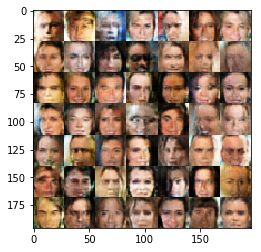

Epoch 1/1 Discriminator loss 1.4118 Generator loss 0.7025
Epoch 1/1 Discriminator loss 1.3967 Generator loss 0.7383
Epoch 1/1 Discriminator loss 1.3618 Generator loss 0.6796
Epoch 1/1 Discriminator loss 1.3394 Generator loss 0.7977
Epoch 1/1 Discriminator loss 1.3502 Generator loss 0.7638
Epoch 1/1 Discriminator loss 1.3231 Generator loss 0.7762
Epoch 1/1 Discriminator loss 1.3360 Generator loss 0.9032
Epoch 1/1 Discriminator loss 1.3111 Generator loss 0.8121
Epoch 1/1 Discriminator loss 1.3745 Generator loss 0.8108
Epoch 1/1 Discriminator loss 1.3547 Generator loss 0.7245
(?, 28, 28, 3)


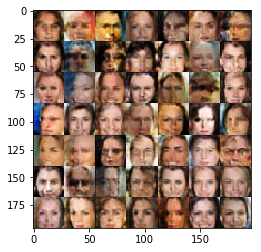

Epoch 1/1 Discriminator loss 1.3954 Generator loss 0.7695
Epoch 1/1 Discriminator loss 1.3429 Generator loss 0.8014
Epoch 1/1 Discriminator loss 1.3089 Generator loss 0.9065
Epoch 1/1 Discriminator loss 1.4025 Generator loss 0.7566
Epoch 1/1 Discriminator loss 1.3540 Generator loss 0.7973
Epoch 1/1 Discriminator loss 1.3508 Generator loss 0.7677
Epoch 1/1 Discriminator loss 1.3727 Generator loss 0.7202
Epoch 1/1 Discriminator loss 1.3441 Generator loss 0.8979
Epoch 1/1 Discriminator loss 1.3491 Generator loss 0.8309
Epoch 1/1 Discriminator loss 1.3544 Generator loss 0.7453
(?, 28, 28, 3)


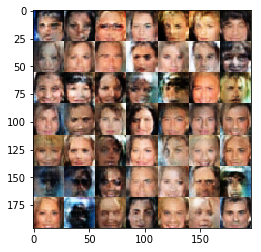

Epoch 1/1 Discriminator loss 1.3053 Generator loss 0.8551
Epoch 1/1 Discriminator loss 1.3319 Generator loss 0.7421
Epoch 1/1 Discriminator loss 1.3964 Generator loss 0.6832
Epoch 1/1 Discriminator loss 1.3372 Generator loss 0.8267
Epoch 1/1 Discriminator loss 1.3420 Generator loss 0.8091
Epoch 1/1 Discriminator loss 1.3801 Generator loss 0.7917
Epoch 1/1 Discriminator loss 1.3748 Generator loss 0.8424
Epoch 1/1 Discriminator loss 1.3540 Generator loss 0.8418
Epoch 1/1 Discriminator loss 1.3926 Generator loss 0.7583
Epoch 1/1 Discriminator loss 1.3448 Generator loss 0.7719
(?, 28, 28, 3)


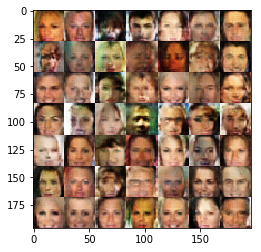

Epoch 1/1 Discriminator loss 1.3199 Generator loss 0.7965
Epoch 1/1 Discriminator loss 1.3621 Generator loss 0.7904
Epoch 1/1 Discriminator loss 1.3039 Generator loss 0.8306
Epoch 1/1 Discriminator loss 1.3742 Generator loss 0.7932
Epoch 1/1 Discriminator loss 1.4173 Generator loss 0.7695
Epoch 1/1 Discriminator loss 1.3462 Generator loss 0.7991
Epoch 1/1 Discriminator loss 1.3566 Generator loss 0.7634
Epoch 1/1 Discriminator loss 1.3174 Generator loss 0.9234
Epoch 1/1 Discriminator loss 1.3710 Generator loss 0.8355
Epoch 1/1 Discriminator loss 1.3636 Generator loss 0.8077
(?, 28, 28, 3)


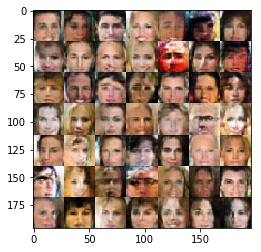

Epoch 1/1 Discriminator loss 1.3168 Generator loss 0.8515
Epoch 1/1 Discriminator loss 1.3520 Generator loss 0.8905
Epoch 1/1 Discriminator loss 1.3603 Generator loss 0.8317
Epoch 1/1 Discriminator loss 1.3917 Generator loss 0.7835
Epoch 1/1 Discriminator loss 1.3115 Generator loss 0.8135
Epoch 1/1 Discriminator loss 1.3021 Generator loss 0.8863


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.